# 11. Comparing Density Profiles of the Simulation and Model

Like what we did with the temperature data, we want to use `plot_spherical.py` to produce the radial profile data for the `rho` variable, which is the gas density. Here's what you'll need to run in the terminal to produce this data:

`python plot_spherical.py -a -m diskmc.out1.00001.athdf rho test.png`

This turns on averaging and midplane, and will output a data file called `exported_data_rho.npy`. 

In [2]:
import numpy as np
r_data, rho_data = np.load("/home/connor/Documents/thindisk/data/exported_data_rho.npy")

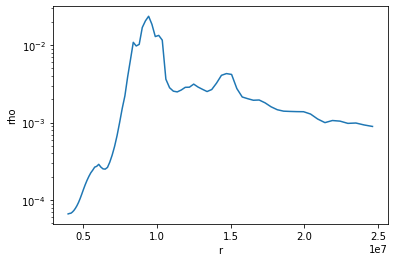

In [3]:
import matplotlib.pyplot as plt
plt.plot(r_data, rho_data)
plt.yscale('log')
plt.xlabel('r')
plt.ylabel('rho')
plt.show()

Neat, that's a good-looking density profile. Let's see if we can get a nice theoretical model plotted over this data.

The model described in Shakura & Sunyaev 1973 has some strange notation, but we can plug it in to a function in code just like they have it written out.

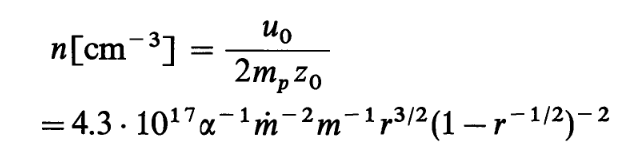
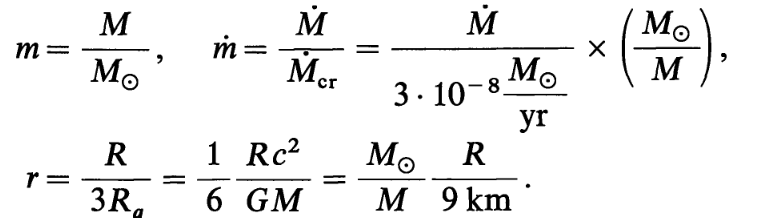

In [30]:
import astropy.constants as c
import astropy.units as u

def num_dens(R, M, Mdot, alpha):
    m = (M / c.M_sun).decompose()
    mdot = (Mdot / (3e-8 * u.solMass / u.yr) * c.M_sun / M).decompose()
    r = (c.M_sun * R / M / (9*u.km)).decompose()
    return 4.3e17 * alpha**(-1) * mdot**(-2) * m**(-1) * r**(3/2) * (1 - r**(-1/2))**(-2) * 1/u.cm**3

def r_grav(M):
    return (c.G*M/c.c.cgs**2).to(u.cm)

In [31]:
num_dens(9e5*u.cm, 6.63*u.solMass, 3e-8*u.solMass/u.yr, 1.)* c.m_p.cgs

<Quantity 1.1261994e-07 g / cm3>

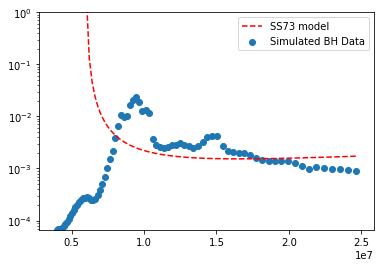

In [32]:
# Values for mass of the black hole and accretion rate
M = 6.62*u.solMass
Mdot = 0.000000009*u.solMass/u.yr

r_model = np.linspace(M/u.solMass * 9.1e5, r_data[-1], 100)*u.cm # Create model r points
rho_model = num_dens(r_model, M, Mdot, 1.)* c.m_p.cgs # Calculate density at each r point using the model function
plt.plot(r_model, rho_model, 'r--', label='SS73 model') # plot the model
plt.scatter(r_data, rho_data, label='Simulated BH Data') # plot the data
plt.legend()
plt.yscale('log')
plt.ylim((min(rho_data), 1))
plt.show()

We can also do a linear fit in log space like we did for the temperature data. This time instead of doing an exponential fit, let's do a **power-law fit**. They're subtly different in the equations used. A power law takes the form

`y = ax^(k)`

So, to do this fit in log space, we're going to take the log of **both the x and y axes** to get this:

`log y = log a + k * log x`

This looks like our `mx + b` linear fit equation, except now we have `b = log a` and `m = k`. When we ask numpy ot create our fit, it will give us `b` and `m`. So, to get these values back into linear space, lets make the substitution of these variables and then see what our powerlaw equation will need to look like.

`log y = b + m * log x`

`10^(log y) = 10^(b + m * log x)`

`10^(log y) = 10^(b + log x^m)`

`10^(log y) = 10^(b) * 10^(log x^m)`

`y = 10^(b) * x^(m)`

So, once we get our fit constants `b` and `m`, now we know how to use them to get our powerlaw relation, and we can make a statement like "The density falls off as `x` to the power of `m`."

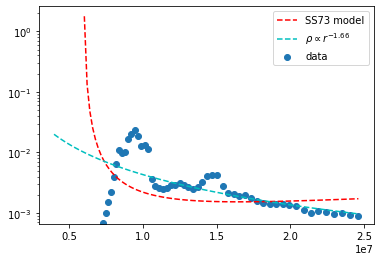

In [33]:
z = np.polyfit(np.log10(r_data[42:]), np.log10(rho_data)[42:], 1)
m = z[0]
b = z[1]
log_fit = 10**(b) * r_data**(m)
plt.scatter(r_data, rho_data, label='data')
plt.plot(r_model, rho_model, 'r--', label='SS73 model')
plt.plot(r_data, log_fit, 'c--', label=r'$\rho \propto r^{{{:.2f}}}$'.format(m))
plt.yscale('log')
plt.legend()
plt.show()

Note that for the power law fit, I've explicitly ignored the first 42 data points. That's because the power-law behavior doesn't start until after the "peak" of the density, around r=1e7. 